In [1]:
# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# import torchvision
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob

In [2]:
# training parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 100
num_songs_per_folder = 250
precent_data_used = .25
window_size = 88
num_classes = 100
training_dir = '/home/george-vengrovski/Documents/tweetynet_freeze/tweetynet_freeze/data/training'
holdout_dir = '/home/george-vengrovski/Documents/tweetynet_freeze/tweetynet_freeze/data/holdout'

## For Generating Training Windows

In [3]:
## slice up into windows
# dir = '/home/george-vengrovski/Documents/tweetynet_freeze/backup/training'

# training_folders = glob.glob(dir + '/*')

# print(training_folders)

# for folder in training_folders:
#     songs = glob.glob(folder + '/*')
#     # for sorted 
#     songs.sort()
#     for i, song in enumerate(songs):
#         if i > num_songs_per_folder:
#             break
#         name = song.split('/')[-1]
#         print(name)
#         song = np.load(song)
#         for slice in range(0, song.shape[1] - window_size, window_size):
#             window = song[:,slice:slice+window_size]
#             print(window.shape)
#             np.save(training_dir + '/' + str(slice)+ '_'+ name , window)

In [4]:
def collate_tensor_fn(batch):
    max_length = 0

    # Find the maximum length along the third dimension
    for b in batch:
        if b[0].shape[2] > max_length:
            max_length = b[0].shape[2]

    # Pad tensors to the maximum length
    padded_batch = []
    for b in batch:
        tensor, labels = b
        padded_tensor = F.pad(tensor, (0, max_length - tensor.shape[2]))
        padded_labels = F.pad(labels, (0, max_length - labels.shape[2]))
        padded_batch.append((padded_tensor, padded_labels))

    # Stack the padded tensors
    specs = torch.stack([b[0] for b in padded_batch])
    labels = torch.stack([b[1] for b in padded_batch])

    return specs, labels


class NumpyDataset(Dataset):
    def __init__(self, train_dir, transform=None):
        self.transform = transform
        self.specs = []
        self.labels = []
    
        for file in sorted(os.listdir(train_dir)):
            file_type = file.split('_')[-1]
            file_type = file_type.split('.')[0]
            if file_type == 'spec':
                spec = np.load(training_dir + '/' + file)
                file_name = file.split('_')[0:-1]
                file_name = '_'.join(file_name)
                labels = np.load(training_dir + '/' + file_name + '_labels.npy')
                # add dimension of 1 to spec 
                spec = np.expand_dims(spec, axis=0)
                self.specs.append(spec)
                self.labels.append(labels)

    def __getitem__(self, index):
        specs = self.specs[index]
        labels = self.labels[index]

        labels = self.one_hot(labels)
        # swap dim 1 and dim 2
        labels = np.swapaxes(labels, 1, 2)

        if self.transform:
            specs = self.transform(specs)
            
        return (specs, labels)
   
    def __len__(self):
        return len(self.specs)
    
    def one_hot(self, arr):
        return F.one_hot(torch.from_numpy(arr).long(), num_classes=num_classes).float()

# Transform function to convert numpy arrays to tensors
def to_tensor(arr):
    return torch.from_numpy(arr).float()

# Create the transformation pipeline
transform = transforms.Compose([
    to_tensor  # Convert numpy arrays to tensors
])

# Create the dataset without the transform
train_dataset = NumpyDataset(train_dir=training_dir, transform=transform)

# Use the dataset in the data loader with the collate_fn argument
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_tensor_fn)


## Model

In [5]:
class Conv2dTF(nn.Conv2d):

    PADDING_METHODS = ('VALID', 'SAME')

    """Conv2d with padding behavior from Tensorflow
    adapted from
    https://github.com/mlperf/inference/blob/16a5661eea8f0545e04c86029362e22113c2ec09/others/edge/object_detection/ssd_mobilenet/pytorch/utils.py#L40
    as referenced in this issue:
    https://github.com/pytorch/pytorch/issues/3867#issuecomment-507025011
    used to maintain behavior of original implementation of TweetyNet that used Tensorflow 1.0 low-level API
    """
    def __init__(self, *args, **kwargs):
        # remove 'padding' from ``kwargs`` to avoid bug in ``torch`` => 1.7.2
        # see https://github.com/yardencsGitHub/tweetynet/issues/166
        kwargs_super = {k: v for k, v in kwargs.items() if k != 'padding'}
        super(Conv2dTF, self).__init__(*args, **kwargs_super)
        padding = kwargs.get("padding", "SAME")
        if not isinstance(padding, str):
            raise TypeError(f"value for 'padding' argument should be a string, one of: {self.PADDING_METHODS}")
        padding = padding.upper()
        if padding not in self.PADDING_METHODS:
            raise ValueError(
                f"value for 'padding' argument must be one of '{self.PADDING_METHODS}' but was: {padding}"
            )
        self.padding = padding

    def _compute_padding(self, input, dim):
        input_size = input.size(dim + 2)
        filter_size = self.weight.size(dim + 2)
        effective_filter_size = (filter_size - 1) * self.dilation[dim] + 1
        out_size = (input_size + self.stride[dim] - 1) // self.stride[dim]
        total_padding = max(
            0, (out_size - 1) * self.stride[dim] + effective_filter_size - input_size
        )
        additional_padding = int(total_padding % 2 != 0)

        return additional_padding, total_padding

    def forward(self, input):
        if self.padding == "VALID":
            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=0,
                dilation=self.dilation,
                groups=self.groups,
            )
        elif self.padding == "SAME":
            rows_odd, padding_rows = self._compute_padding(input, dim=0)
            cols_odd, padding_cols = self._compute_padding(input, dim=1)
            if rows_odd or cols_odd:
                input = F.pad(input, [0, cols_odd, 0, rows_odd])

            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=(padding_rows // 2, padding_cols // 2),
                dilation=self.dilation,
                groups=self.groups,
            )

class TweetyNet(nn.Module):
    def __init__(self,
                 num_classes,
                 input_shape=(1, 513, 88),
                 padding='SAME',
                 conv1_filters=32,
                 conv1_kernel_size=(5, 5),
                 conv2_filters=64,
                 conv2_kernel_size=(5, 5),
                 pool1_size=(8, 1),
                 pool1_stride=(8, 1),
                 pool2_size=(8, 1),
                 pool2_stride=(8, 1),
                 hidden_size=None,
                 rnn_dropout=0.,
                 num_layers=1,
                 bidirectional=True,
                 ):
        """initialize TweetyNet model
        Parameters
        ----------
        num_classes : int
            number of classes to predict, e.g., number of syllable classes in an individual bird's song
        input_shape : tuple
            with 3 elements corresponding to dimensions of spectrogram windows: (channels, frequency bins, time bins).
            i.e. we assume input is a spectrogram and treat it like an image, typically with one channel,
            the rows are frequency bins, and the columns are time bins. Default is (1, 513, 88).
        padding : str
            type of padding to use, one of {"VALID", "SAME"}. Default is "SAME".
        conv1_filters : int
            Number of filters in first convolutional layer. Default is 32.
        conv1_kernel_size : tuple
            Size of kernels, i.e. filters, in first convolutional layer. Default is (5, 5).
        conv2_filters : int
            Number of filters in second convolutional layer. Default is 64.
        conv2_kernel_size : tuple
            Size of kernels, i.e. filters, in second convolutional layer. Default is (5, 5).
        pool1_size : two element tuple of ints    specs = self.transform(specs)

            Size of sliding window for first max pooling layer. Default is (1, 8)
        pool1_stride : two element tuple of ints
            Step size for sliding window of first max pooling layer. Default is (1, 8)
        pool2_size : two element tuple of ints
            Size of sliding window for second max pooling layer. Default is (1, 8),
        pool2_stride : two element tuple of ints
            Step size for sliding window of second max pooling layer. Default is (1, 8)
        hidden_size : int
            number of features in the hidden state ``h``. Default is None,
            in which case ``hidden_size`` is set to the dimensionality of the
            output of the convolutional neural network. This default maintains
            the original behavior of the network.
        rnn_dropout : float
            If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer,
            with dropout probability equal to dropout. Default: 0
        num_layers : int
            Number of recurrent layers. Default is 1.
        bidirectional : bool
            If True, make LSTM bidirectional. Default is True.
        """
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.cnn = nn.Sequential(
            Conv2dTF(in_channels=self.input_shape[0],
                     out_channels=conv1_filters,
                     kernel_size=conv1_kernel_size,
                     padding=padding
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool1_size,
                         stride=pool1_stride),
            Conv2dTF(in_channels=conv1_filters,
                     out_channels=conv2_filters,
                     kernel_size=conv2_kernel_size,
                     padding=padding,
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool2_size,
                         stride=pool2_stride),
        )

        # determine number of features in output after stacking channels
        # we use the same number of features for hidden states
        # note self.num_hidden is also used to reshape output of cnn in self.forward method
        batch_shape = tuple((1,) + input_shape)
        tmp_tensor = torch.rand(batch_shape)
        tmp_out = self.cnn(tmp_tensor)
        channels_out, freqbins_out = tmp_out.shape[1], tmp_out.shape[2]
        self.rnn_input_size = channels_out * freqbins_out

        if hidden_size is None:
            self.hidden_size = self.rnn_input_size
        else:
            self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size=self.rnn_input_size,
                           hidden_size=self.hidden_size,
                           num_layers=num_layers,
                           dropout=rnn_dropout,
                           bidirectional=bidirectional)

        # for self.fc, in_features = hidden_size * 2 because LSTM is bidirectional
        # so we get hidden forward + hidden backward as output
        self.fc = nn.Linear(in_features=self.hidden_size * 2, out_features=num_classes)

    def forward(self, x):
        features = self.cnn(x)
        # stack channels, to give tensor shape (batch, rnn_input_size, num time bins)
        features = features.view(features.shape[0], self.rnn_input_size, -1)
        # switch dimensions for feeding to rnn, to (num time bins, batch size, input size)
        features = features.permute(2, 0, 1)
        rnn_output, _ = self.rnn(features)
        # permute back to (batch, time bins, hidden size) to project features down onto number of classes
        rnn_output = rnn_output.permute(1, 0, 2)
        logits = self.fc(rnn_output)
        # permute yet again so that dimension order is (batch, classes, time steps)
        # because this is order that loss function expects
        return logits.permute(0, 2, 1)
    
    def loss_function(self, y_pred, y_true):
        """loss function for TweetyNet
        Parameters
        ----------
        y_pred : torch.Tensor
            output of TweetyNet model, shape (batch, time bins, classes)
        y_true : torch.Tensor
            one-hot encoded labels, shape (batch, time bins, classes)
        Returns
        -------
        loss : torch.Tensor
            mean cross entropy loss
        """
        loss = nn.CrossEntropyLoss()
        return loss(y_pred, y_true)
    
    def acc(self, y_pred, y):
        return y_pred.eq(y.view_as(y_pred)).sum().item() / np.prod(y.shape)



In [13]:
model = TweetyNet(num_classes=100, input_shape=(1, 513, 88))
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_for_plot = []

print('Training ...')
for epoch in range(num_epochs):
    print('Epoch %d/%d' % (epoch+1, num_epochs))

    train_loss_avg = []

    for spec, labels in train_loader:
        # list to tensor
        spec = spec.to(device)

        # forward pass
        prediction = model(spec)

        labels = labels.squeeze(1)
        labels = labels.to(device)

        loss = model.loss_function(prediction, labels)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg.append(loss.item())

    if epoch % 10 == 0:
        torch.save(model.state_dict(), '/home/george-vengrovski/Documents/tweetynet_freeze/tweetynet_freeze/training_checkpoints/checkpoint{}'.format(epoch))

    print(f'Epoch: {epoch}')
    print(prediction.shape)
    print(labels.shape)
    print(f"train loss: {np.mean(train_loss_avg)}")
    print(f"accuracy: {model.acc(prediction, labels)}")

    train_loss_for_plot.append(np.mean(train_loss_avg))

Number of parameters: 4357092
Training ...
Epoch 1/100
Epoch: 0
torch.Size([16, 100, 88])
torch.Size([16, 100, 88])
train loss: 0.4820121472982637
accuracy: 0.0
Epoch 2/100
Epoch: 1
torch.Size([16, 100, 88])
torch.Size([16, 100, 88])
train loss: 0.13711462138702338
accuracy: 0.0
Epoch 3/100


KeyboardInterrupt: 

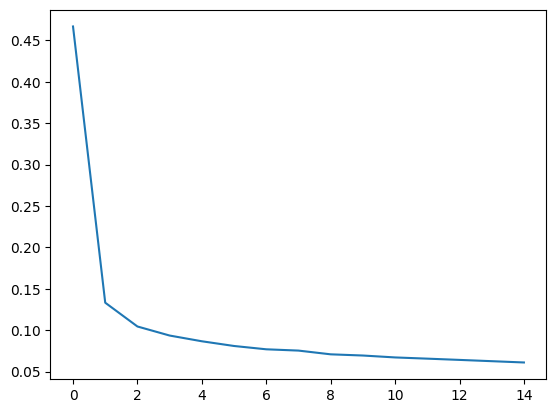

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss_for_plot)

## Validation

In [15]:
# get random test sample
spec, labels = next(iter(train_loader))
spec = spec.to(device)
labels = labels.to(device)

# forward pass
prediction = model(spec)

# print('Prediction shape:', prediction[0].T.shape)
# print(prediction)
print(labels)


tensor([[[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[1., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.